In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from IPython.display import display
from scipy.signal import resample
from scipy import stats
import glob
import sys
import joblib
sys.path.insert(-1,'../Tools')

from data_analysis import df_vcg_vector, plot_vcgs, calc_cost, calc_cost_rms, calc_cost_rms_norm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# Load data

In [2]:
#Load VCG atlas
atlas_file = '../Figure2/VCG_atlas_all.pickle'
pca = joblib.load(atlas_file)

weights_file = '../Figure2/VCG_atlas_all_weights.pickle'
X_weights = joblib.load(weights_file)

In [ ]:
#Load patient data
pt_files = glob.glob('../Data/BiV*/BiV*-LBBB_kVCG_model-out.txt')
pt_files.sort()
print(pt_files)
pt_VCGs = [pd.read_csv(f, header = None, names=['VCGx','VCGy','VCGz'], sep=' ', index_col=False) for f in pt_files] 

# Calculate mode scores for patient VCGs

Using the resampling method to get the patient VCG and simulated VCGs to have the same number of data points

In [4]:
pt_VCG_resamp = [np.nan]*len(pt_VCGs)

for i,df in enumerate(pt_VCGs):
    arr = resample(df.to_numpy(),100)
    pt_VCG_resamp[i] = pd.DataFrame(data = arr,columns = ['VCGx','VCGy','VCGz'])

In [6]:
eigvals = pca.singular_values_
components = np.array(pca.components_)
ncomp = components.shape[0]
nfeat = components.shape[1]

In [ ]:
zscores_resamp = pd.DataFrame()
for i,X in enumerate(pt_VCG_resamp):
    X_new = pd.concat([X['VCGx'],X['VCGy'],X['VCGz']],axis=0,ignore_index=True).to_numpy()
    pcs = pca.transform(X_new.reshape(1,-1))
    zscores_resamp['BiV%s'%str(i+1)] = np.reshape(pcs/np.sqrt(eigvals),ncomp)
zscores_resamp

# Reconstruct patient VCGs from combinations of modes

In [9]:
BiV_z_modes = pd.DataFrame()
for z in zscores_resamp:
    for mode in range(1,21):
        comps = np.arange(mode)
        s = zscores_resamp[z].iloc[0:mode].to_numpy()
        d = s*(np.sqrt(eigvals[comps]).T)
        BiV_z_modes['%s_Mode_%s'%(z,str(mode))] = pca.mean_ + np.dot(d,components[comps])

# Calculate objective function between reconstructed modes and patient VCG

In [15]:
mode_z_obj = np.zeros([ncomp,len(pt_VCGs)])
mode_z_rms_norm = np.zeros([ncomp,len(pt_VCGs)])

for i,pt in enumerate(zscores_resamp):
        for mode in range(1,21):
            mode_z_obj[mode-1,i] = calc_cost(pt_VCG_resamp[i],df_vcg_vector(BiV_z_modes['%s_Mode_%s'%(pt,str(mode))].to_numpy()))
            mode_z_rms_norm[mode-1,i] = calc_cost_rms_norm(pt_VCG_resamp[i],df_vcg_vector(BiV_z_modes['%s_Mode_%s'%(pt,str(mode))].to_numpy()))            

# Average optimal sim error

In [17]:
opt_theta_all = [0.1072, 0.0466, 0.0352, 0.0742, 0.0542, 0.1182, 0.0507, 0.0715]
opt_theta_all = np.array(opt_theta_all)
opt_rms_all = [0.7074, 0.3250, 0.3925, 0.5576, 0.7007, 0.7588, 0.3989, 0.5570]
opt_rms_all = np.array(opt_rms_all)

In [18]:
opt_theta_all.mean()

0.069725

# Plot objective function vs mode

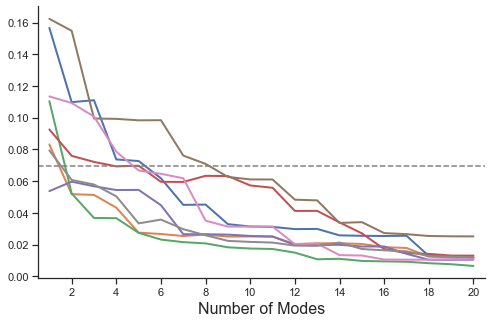

In [21]:
import seaborn as sns; sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (8,5))
x_vals = np.arange(ncomp)+1
for pt in range(8):
    plt.plot(x_vals, mode_z_obj[:,pt], linewidth = 2)
#plt.plot(x_vals, mode_z_obj[:,5],'k--')


ax.set_xlim([0.5, 20.5])
#ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of Modes',fontsize=16)
#ax.set_ylabel(r'$\Theta',fontsize=16)
#ax.set_title('Reconstructed Patient VCGs',fontsize=16)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.axhline(opt_theta_all.mean(),color='0.5',linestyle='--')
sns.despine()
#plt.show()
plt.savefig('Fig3B.pdf', transparent=True)

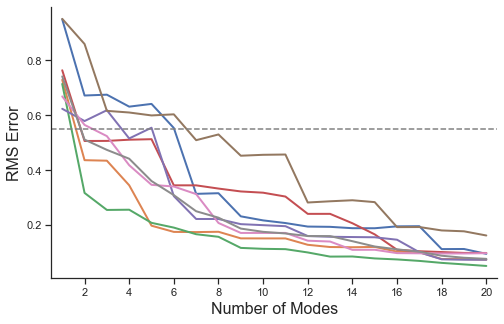

In [27]:
import seaborn as sns; sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (8,5))
x_vals = np.arange(ncomp)+1
for pt in range(8):
    plt.plot(x_vals, mode_z_rms_norm[:,pt], linewidth=2)

ax.set_xlim([0.5, 20.5])
#ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of Modes',fontsize=16)
#ax.set_ylabel('RMS Error (normalized VCG)',fontsize=16)
ax.set_ylabel('RMS Error',fontsize=16)
#ax.set_title('Reconstructed Patient VCGs',fontsize=16)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.axhline(opt_rms_all.mean(),color='0.5',linestyle='--')

sns.despine()

#plt.show()
plt.savefig('Fig3C.pdf', transparent=True)

# Plot mode and patient VCG

In [28]:
def plot_vcgs_xyz(labels, vcg1, vcg2=None, vcg3=None, vcg4=None, ref_lines=False,  title=False, alt_lines=False, vcg_norm=False):
    """Split a vectorized VCG with a single function call

    Arguments
    ---------
    vcg1 : list
        A list containing the x,y, and z components
        of a vcg (i.e. [vcg_x,vcg_y,vcg_z])

    vcg2 : list
        A list containing the x,y, and z components
        of a vcg (i.e. [vcg_x,vcg_y,vcg_z])

    labels : list
        A list containing the labels for plotting

    Returns
    -------
    vcg_x,vcg_y,vcg_z : numpy.array
        The seperated vcg components
    """
    if vcg_norm:
        vcg1 = vcg1/max(np.linalg.norm(vcg1, axis=1))
    
    sns.reset_orig()
    fig = plt.figure(figsize=(5, 4))
    fig.patch.set_facecolor('white')
    ax1 = plt.subplot2grid((7, 6), (0, 0), colspan=7, rowspan=2)
    ax2 = plt.subplot2grid((7, 6), (2, 0), colspan=7, rowspan=2)
    ax3 = plt.subplot2grid((7, 6), (4, 0), colspan=7, rowspan=2)

    # p_txt = fig.text(0.35,.89,f.split('/')[-1], fontsize = 16, ha='center')
    if title:
        fig.suptitle(title, fontsize=18,fontweight='bold')

    t = np.arange(len(vcg1['VCGx']))

    ax1.plot(t, vcg1['VCGx'], 'k-', linewidth=2)
    if ref_lines: ax1.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.0')
    ax1.set_title('X',x=0,y=0.8, fontsize=16)
    ax1.axis('off')

    ax2.plot(t, vcg1['VCGy'], 'k-', linewidth=2)
    if ref_lines: ax2.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.0')
    ax2.set_title('Y',x=0,y=0.8, fontsize=16)
    ax2.axis('off')

    ax3.plot(t, vcg1['VCGz'], 'k-', linewidth=2,label=labels[0])
    if ref_lines: ax3.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.0')
    ax3.set_title('Z', x=0, y=0.8, fontsize=16)
    ax3.axis('off')


    if alt_lines:
        line_style = alt_lines
    else:
        line_style = ['b-','r-','g-']

    if isinstance(vcg2, pd.DataFrame):
        if vcg_norm:
            vcg2 = vcg2/max(np.linalg.norm(vcg2, axis=1))
        t_vcg = np.arange(len(vcg2['VCGx']))
        ax1.plot(t_vcg, vcg2['VCGx'], linewidth=2)#, line_style[0])
        ax2.plot(t_vcg, vcg2['VCGy'], linewidth=2)#, line_style[0])
        ax3.plot(t_vcg, vcg2['VCGz'], linewidth=2, label=labels[1])#, line_style[0], )
    if isinstance(vcg3, pd.DataFrame):
        if vcg_norm:
            vcg3 = vcg3/max(np.linalg.norm(vcg3, axis=1))
        t_vcg = np.arange(len(vcg3['VCGx']))
        ax1.plot(t_vcg, vcg3['VCGx'], linewidth=2)#, line_style[1])
        ax2.plot(t_vcg, vcg3['VCGy'], linewidth=2)#, line_style[1])
        ax3.plot(t_vcg, vcg3['VCGz'], linewidth=2, label=labels[2])#, line_style[1])
    if isinstance(vcg4, pd.DataFrame):
        if vcg_norm:
            vcg4 = vcg4/max(np.linalg.norm(vcg4, axis=1))
        t_vcg = np.arange(len(vcg4['VCGx']))
        ax1.plot(t_vcg, vcg4['VCGx'], linewidth=2)#, line_style[2])
        ax2.plot(t_vcg, vcg4['VCGy'], linewidth=2)#, line_style[2])
        ax3.plot(t_vcg, vcg4['VCGz'], linewidth=2, label=labels[3])#, line_style[2], label=labels[3])

    ax3.legend(prop={'size': 16}, frameon=False, bbox_to_anchor=(0.7,0))

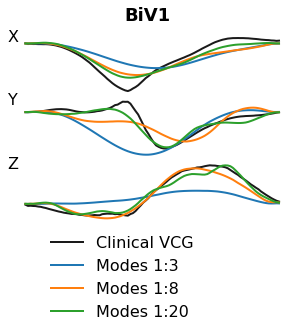

In [29]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[0],
              df_vcg_vector(BiV_modes['BiV1_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV1_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV1_Mode_20'].to_numpy()),
              title='BiV1')

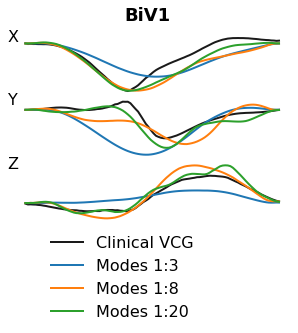

In [30]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[0],
              df_vcg_vector(BiV_modes['BiV1_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV1_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV1_Mode_20'].to_numpy()),
              title='BiV1',vcg_norm=True)
plt.savefig('Fig3A-1.pdf', transparent=True)

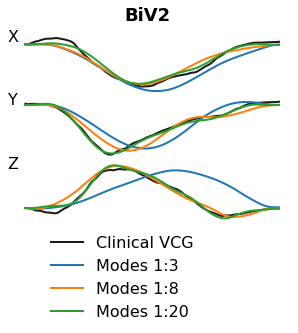

In [31]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[1],
              df_vcg_vector(BiV_modes['BiV2_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV2_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV2_Mode_20'].to_numpy()),
              title='BiV2',vcg_norm=True)

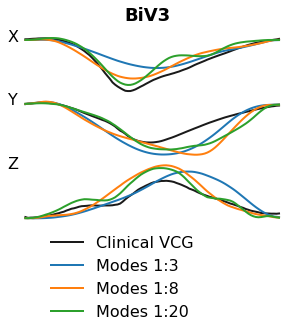

In [32]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[2],
              df_vcg_vector(BiV_modes['BiV3_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV3_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV3_Mode_20'].to_numpy()),
              title='BiV3',vcg_norm=True)
plt.savefig('Fig3A-2.pdf', transparent=True)

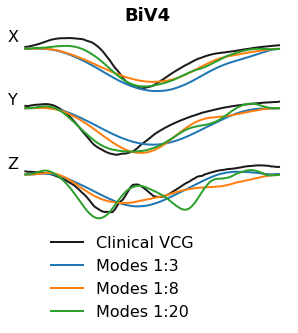

In [33]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[3],
              df_vcg_vector(BiV_modes['BiV4_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV4_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV4_Mode_20'].to_numpy()),
              title='BiV4',vcg_norm=True)

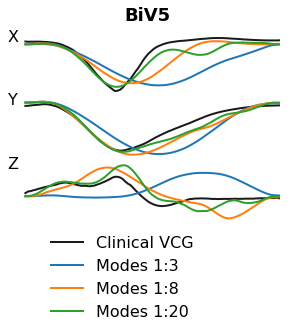

In [34]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[4],
              df_vcg_vector(BiV_modes['BiV5_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV5_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV5_Mode_20'].to_numpy()),
              title='BiV5',vcg_norm=True)

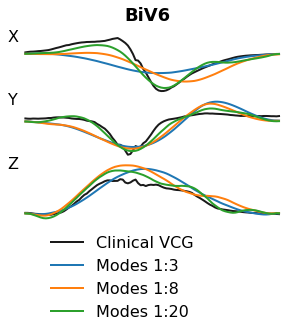

In [35]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[5],
              df_vcg_vector(BiV_modes['BiV6_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV6_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV6_Mode_20'].to_numpy()),
              title='BiV6',vcg_norm=True)
plt.savefig('Fig3A-3.pdf', transparent=True)

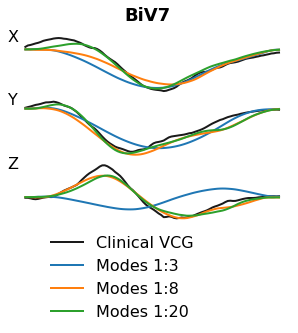

In [36]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[6],
              df_vcg_vector(BiV_modes['BiV7_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV7_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV7_Mode_20'].to_numpy()),
              title='BiV7',vcg_norm=True)

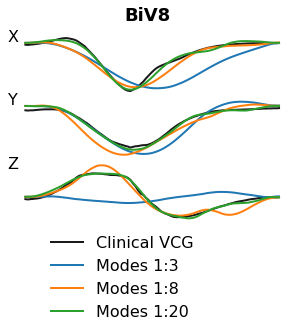

In [37]:
plot_vcgs_xyz(['Clinical VCG','Modes 1:3','Modes 1:8','Modes 1:20'], pt_VCG_resamp[7],
              df_vcg_vector(BiV_modes['BiV8_Mode_3'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV8_Mode_8'].to_numpy()),
              df_vcg_vector(BiV_modes['BiV8_Mode_20'].to_numpy()),
              title='BiV8',vcg_norm=True)